In [ ]:
# Import necessary libraries for data manipulation, visualization, audio processing, and deep learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
from itertools import cycle
import os
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import random
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.optim as optim
import torch.nn as nn
from huggingface_hub import login  # For Hugging Face authentication
import pickle  # For loading serialized data
import sys



In [ ]:
# Set the theme for seaborn plots to have a white background
sns.set_theme(style="white", palette=None)

# Retrieve the default color cycle for plotting
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(color_pal)

# Authenticate with Hugging Face using the token stored in environment variables
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

# Mount Google Drive to access data files
drive.mount('/content/drive')

# Define and set the working directory to the TESI project folder in Google Drive
tesi_path = '/content/drive/My Drive/TESI'
os.chdir(tesi_path)
print("Current working directory:", os.getcwd())



Mounted at /content/drive
Current working directory: /content/drive/My Drive/TESI


In [ ]:
def print_updrs_distribution(data, label_key='label', updrs_keys=['updrs', 'UPDRS']):
    """
    Prints the distribution of data based on UPDRS levels and labels.

    Args:
        data (list): Dataset containing 'label' and 'updrs' or 'UPDRS' information.
        label_key (str): Key for the label (0 = control, 1 = Parkinsonian).
        updrs_keys (list): Possible keys for the UPDRS value in the data.
    """
    # Counters for labels and UPDRS
    updrs_counts = defaultdict(int)
    control_count, parkinsonian_count = 0, 0

    for item in data:
        print(f"Item: {item}")  # Debug: Stampa l'elemento corrente
        if label_key in item:
            label = item[label_key]
            print(f"Label: {label}")  # Debug: Stampa il valore del label
            if label == 0:
                control_count += 1
            elif label == 1:
                parkinsonian_count += 1

        updrs_value = None
        for key in updrs_keys:
            if key in item:
                updrs_value = item[key]
                print(f"UPDRS: {updrs_value}")  # Debug: Stampa il valore di UPDRS
                break

        # Increment the count for the UPDRS level
        if updrs_value is not None:
            updrs_counts[updrs_value] += 1

    # Print results
    print(f"Number of controls: {control_count}")
    print(f"Number of Parkinsonians: {parkinsonian_count}")
    print("UPDRS Distribution:")
    for updrs_value, count in sorted(updrs_counts.items()):
        print(f"  UPDRS {updrs_value}: {count}")


Pickle file loaded successfully.


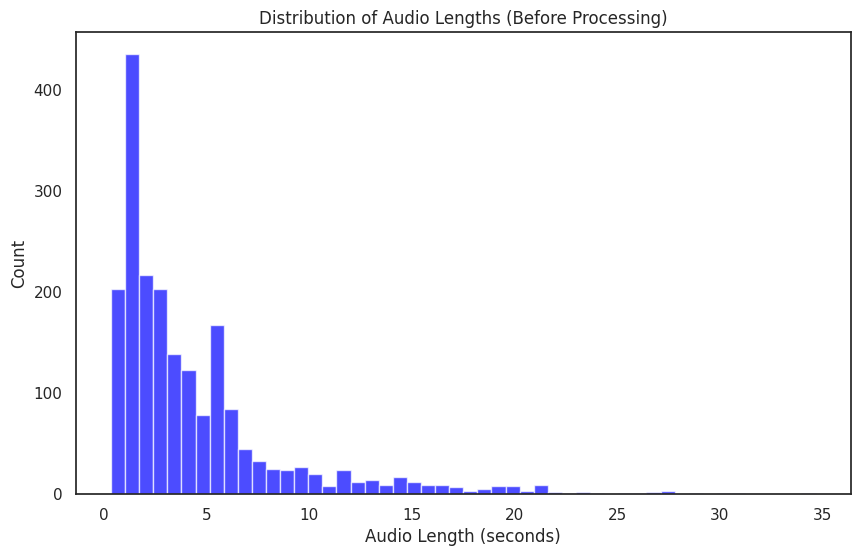

Number of audios: 1997
Minimum audio length: 0.36 seconds
Maximum audio length: 34.66 seconds


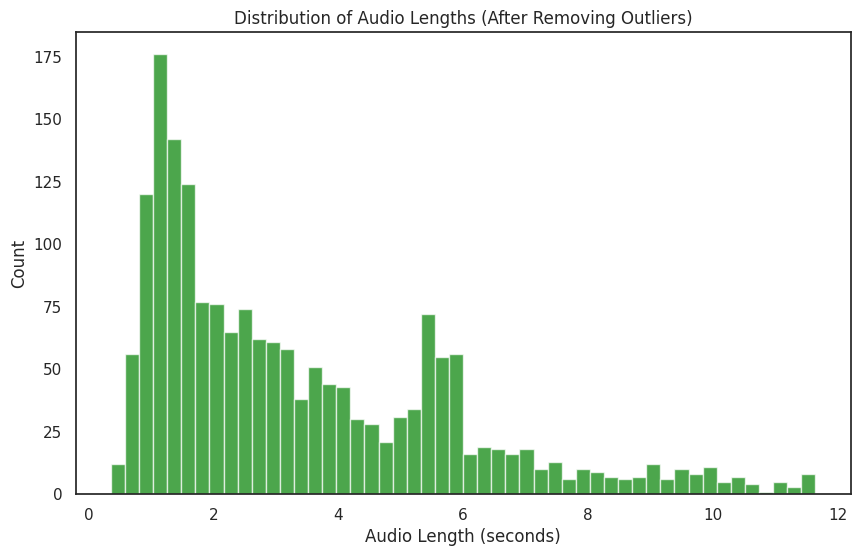

Number of audios after removing outliers: 1841
Minimum audio length after filtering: 0.36 seconds
Maximum audio length after filtering: 11.64 seconds
The shortest audio length is: 0.36 seconds (15872 samples)
Number of audios after removing outliers: 1841
Minimum audio length after filtering: 0.36 seconds
Maximum audio length after filtering: 11.64 seconds
The shortest audio length is: 0.36 seconds (15872 samples)
Processing audios and creating Mel-Spectrograms for the first and last halves...
All audios have been processed and Mel-Spectrograms created for both halves.


In [ ]:
# Define the path to the pickle file containing the dataset
file_path = '/content/drive/MyDrive/TESI/newdata_updated.pkl'

# Load the dataset into the 'newdata' variable
with open(file_path, 'rb') as f:
    newdata = pickle.load(f)

print("Pickle file loaded successfully.")

# Define the standard audio sampling rate
sampling_rate = 44100  # 44.1 kHz

# Calculate audio lengths in samples and convert to seconds
audio_lengths = [len(item['audio']) for item in newdata]
audio_lengths_sec = [length / sampling_rate for length in audio_lengths]

# Plot the distribution of audio lengths before processing
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths_sec, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Audio Lengths (Before Processing)')
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Count')
plt.show()

# Print statistics about the audio lengths
print(f"Number of audios: {len(audio_lengths_sec)}")
print(f"Minimum audio length: {min(audio_lengths_sec):.2f} seconds")
print(f"Maximum audio length: {max(audio_lengths_sec):.2f} seconds")

# Remove outliers based on audio length using the Interquartile Range (IQR) method
q1 = np.percentile(audio_lengths, 25)
q3 = np.percentile(audio_lengths, 75)
iqr = q3 - q1

# Define acceptable range for audio lengths
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter audios within the acceptable range
filtered_data = [item for item in newdata if lower_bound <= len(item['audio']) <= upper_bound]

# Extract lengths after filtering
filtered_audio_lengths = [len(item['audio']) for item in filtered_data]
filtered_audio_lengths_sec = [length / sampling_rate for length in filtered_audio_lengths]

# Plot the distribution after filtering
plt.figure(figsize=(10, 6))
plt.hist(filtered_audio_lengths_sec, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Audio Lengths (After Removing Outliers)')
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Count')
plt.show()

# Print statistics after filtering
print(f"Number of audios after removing outliers: {len(filtered_audio_lengths_sec)}")
print(f"Minimum audio length after filtering: {min(filtered_audio_lengths_sec):.2f} seconds")
print(f"Maximum audio length after filtering: {max(filtered_audio_lengths_sec):.2f} seconds")

# Find the shortest audio length (n) in samples
min_length = min(filtered_audio_lengths)
print(f"The shortest audio length is: {min_length / sampling_rate:.2f} seconds ({min_length} samples)")

# Print statistics after filtering
print(f"Number of audios after removing outliers: {len(filtered_audio_lengths_sec)}")  # Number after filtering
print(f"Minimum audio length after filtering: {min(filtered_audio_lengths_sec):.2f} seconds")  # New minimum
print(f"Maximum audio length after filtering: {max(filtered_audio_lengths_sec):.2f} seconds")  # New maximum

# Find the shortest audio length (n) in samples
min_length = min(filtered_audio_lengths)  # Minimum length in samples
print(f"The shortest audio length is: {min_length / sampling_rate:.2f} seconds ({min_length} samples)")  # Print shortest length

# Update 'newdata' to 'filtered_data' for further processing
newdata = filtered_data

# Function to extract the first and last halves of an audio signal
def extract_first_last_halves(audio, min_length):
    """
    Extracts the first and last halves of the audio signal, ensuring uniform length.
    Pads with zeros if necessary.
    """
    n_half = min_length // 2
    if len(audio) >= min_length:
        first_half = audio[:n_half]
        last_half = audio[-n_half:]
    else:
        padding = min_length - len(audio)
        audio_padded = np.pad(audio, (0, padding), 'constant')
        first_half = audio_padded[:n_half]
        last_half = audio_padded[-n_half:]
    return first_half, last_half

# Process each audio in the dataset
print("Processing audios and creating Mel-Spectrograms for the first and last halves...")
for item in newdata:
    audio = np.array(item['audio'])
    first_half, last_half = extract_first_last_halves(audio, min_length)

    # Generate Mel spectrograms for both halves
    mel_spec_first = librosa.feature.melspectrogram(y=first_half, sr=sampling_rate)
    mel_spec_last = librosa.feature.melspectrogram(y=last_half, sr=sampling_rate)

    # Convert power spectrogram to decibel (dB) units
    mel_spec_first_db = librosa.power_to_db(mel_spec_first, ref=np.max)
    mel_spec_last_db = librosa.power_to_db(mel_spec_last, ref=np.max)

    # Update the item with the two spectrograms
    item['mel_spec_first'] = mel_spec_first_db
    item['mel_spec_last'] = mel_spec_last_db

    # Remove the raw audio to save memory
    del item['audio']

print("All audios have been processed and Mel-Spectrograms created for both halves.")


Converting Mel-Spectrograms to RGB images...
Conversion to RGB images completed.


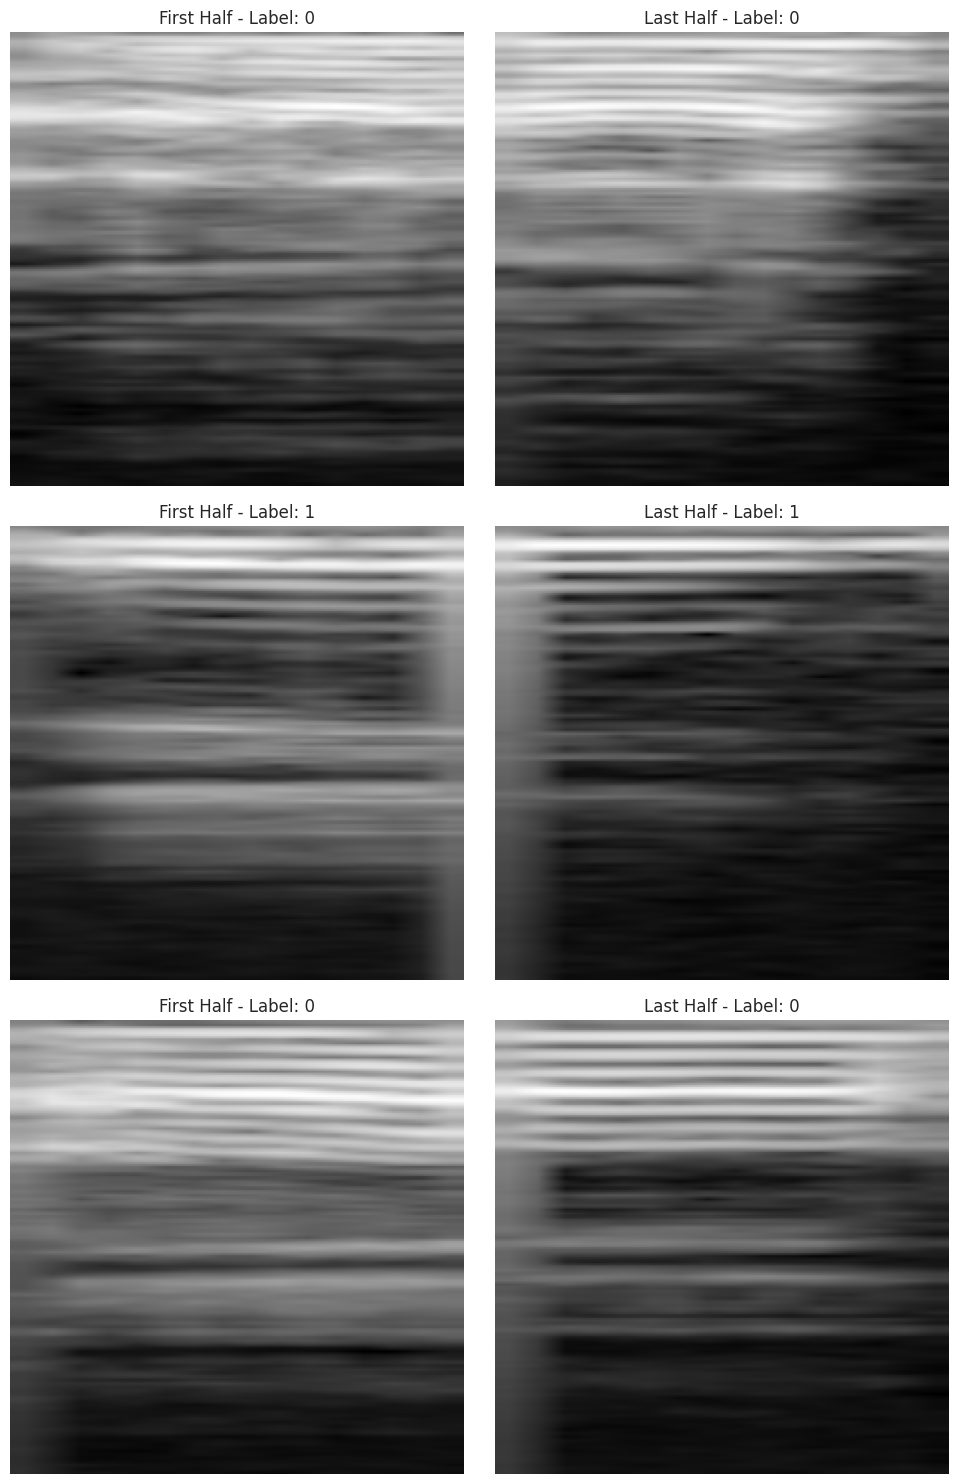

In [ ]:
# Function to convert a Mel-Spectrogram to a 3-channel RGB image
def convert_to_rgb(mel_spec):
    """
    Converts a Mel-Spectrogram to a 3-channel RGB image suitable for ViT input.
    """
    # Resize the spectrogram to 224x224 (ViT input size)
    resized_mel_spec = cv2.resize(mel_spec, (224, 224))

    # Normalize the spectrogram to [0, 1]
    normalized_mel_spec = (resized_mel_spec - np.min(resized_mel_spec)) / (np.max(resized_mel_spec) - np.min(resized_mel_spec))

    # Convert to 3 channels by stacking
    rgb_image = np.stack([normalized_mel_spec]*3, axis=-1)
    return rgb_image

# Convert all Mel-Spectrograms to RGB images
print("Converting Mel-Spectrograms to RGB images...")
for item in newdata:
    # Convert first half spectrogram
    mel_spec_first = item['mel_spec_first']
    rgb_image_first = convert_to_rgb(mel_spec_first)
    item['image_first'] = rgb_image_first  # Save the RGB image of the first half

    # Convert last half spectrogram
    mel_spec_last = item['mel_spec_last']
    rgb_image_last = convert_to_rgb(mel_spec_last)
    item['image_last'] = rgb_image_last  # Save the RGB image of the last half

    # Remove the Mel-Spectrograms to save memory
    del item['mel_spec_first']
    del item['mel_spec_last']

print("Conversion to RGB images completed.")


# Function to plot random samples of the RGB images
def plot_random_mel_spectrograms(data, num_samples=5):
    """
    Plots random pairs of Mel-Spectrogram RGB images with their labels.
    """
    random_samples = random.sample(data, num_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i, sample in enumerate(random_samples):
        image_first = sample['image_first']
        image_last = sample['image_last']
        label = sample['label']

        axes[i, 0].imshow(image_first)
        axes[i, 0].set_title(f"First Half - Label: {label}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(image_last)
        axes[i, 1].set_title(f"Last Half - Label: {label}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Plot random samples
plot_random_mel_spectrograms(newdata, num_samples=3)



In [ ]:
# Define the custom Dataset class
class AudioDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Initializes the dataset.
        Args:
            data (list): List of data samples, each containing 'image_first', 'image_last', and 'label'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a sample and its label at the given index.
        Args:
            idx (int): Index of the sample.
        Returns:
            image_first (tensor): Transformed image tensor of the first half.
            image_last (tensor): Transformed image tensor of the last half.
            label (int): Corresponding label.
        """
        sample = self.data[idx]
        image_first = sample['image_first']
        image_last = sample['image_last']
        label = sample['label']

         # Controlla se esistono le chiavi 'updrs' o 'UPDRS'
        if 'updrs' in sample:
            updrs_value = sample['updrs']
        elif 'UPDRS' in sample:
            updrs_value = sample['UPDRS']
        else:
            updrs_value = -1  # Assegna -1 se nessuna chiave è presente

        metadata = {'updrs': updrs_value}

        if self.transform:
            image_first = self.transform(image_first)
            image_last = self.transform(image_last)

        return image_first, image_last, label, metadata

# Define data transformations (data augmentation and normalization)
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Normalize the tensor
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10)  # Random rotation up to 10 degrees
])

# Group the data by subject ID for stratified splitting
grouped_by_id = defaultdict(list)
for item in newdata:
    grouped_by_id[item['id']].append(item)

# List of all unique subject IDs
all_ids = list(grouped_by_id.keys())

# Function to perform stratified group split based on subject IDs and labels
def stratified_group_split(all_ids, grouped_by_id, label_key='label'):
    """
    Splits the dataset into stratified groups while maintaining balance between classes.
    Args:
        all_ids (list): List of all subject IDs.
        grouped_by_id (dict): Dictionary grouping data by subject ID.
        label_key (str): Key to access the label in the data.
    Returns:
        folds (list): List of folds with balanced subject IDs.
    """
    # Separate IDs based on labels
    controls = [id_ for id_ in all_ids if grouped_by_id[id_][0][label_key] == 0]
    parkinsons = [id_ for id_ in all_ids if grouped_by_id[id_][0][label_key] == 1]

    # Shuffle the IDs to ensure random distribution
    random.shuffle(controls)
    random.shuffle(parkinsons)

    # Define the number of folds for cross-validation
    num_folds = 5

    # Calculate the number of IDs per fold
    split_controls = len(controls) // num_folds
    split_parkinsons = len(parkinsons) // num_folds

    folds = []

    for i in range(num_folds):
        # Get IDs for the current fold
        fold_controls = controls[i * split_controls:(i + 1) * split_controls]
        fold_parkinsons = parkinsons[i * split_parkinsons:(i + 1) * split_parkinsons]
        # Combine IDs and add to folds
        folds.append(fold_controls + fold_parkinsons)

    return folds


In [ ]:
from sklearn.metrics import confusion_matrix

def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity based on confusion matrix.
    Args:
        y_true: True labels.
        y_pred: Predicted labels.
    Returns:
        Specificity (float): True Negative Rate.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity


In [ ]:
def analyze_updrs(val_loader, model, device):
    """
    Analyze logits and probabilities by UPDRS levels for AST model with dual inputs.

    Args:
        val_loader: Validation data loader.
        model: Trained DualInputASTModel.
        device: Device (CPU or GPU).

    Returns:
        updrs_stats (dict): Dictionary with detailed metrics for each UPDRS level.
    """
    # Initialize dictionaries for results and statistics
    updrs_results = {0: [], 1: [], 2: [], 3: [], 4: []}
    control_stats = {'correct': 0, 'total': 0, 'control_prob': []}  # For label 0 (control)

    with torch.no_grad():
        for inputs_first, inputs_last, labels, metadata in val_loader:
            inputs_first = inputs_first.to(device)
            inputs_last = inputs_last.to(device)
            labels = labels.to(device)

            # Forward pass to get logits
            logits_first = model(inputs_first).logits  # Pass inputs_first individually
            logits_last = model(inputs_last).logits    # Pass inputs_last individually
            logits = (logits_first + logits_last) / 2  # Combine the outputs


            # Compute probabilities for the Parkinsonian class
            probabilities = torch.softmax(logits, dim=1)[:, 1]  # Parkinsonian probabilities
            logits = logits[:, 1]  # Parkinsonian logits

            # Iterate over each sample in the batch
            for i, prob in enumerate(probabilities.cpu().numpy()):
                logit = logits[i].item()

                # Access UPDRS value from metadata if available
                updrs_value = None
                if 'updrs' in metadata:
                    updrs_value = metadata['updrs'][i]
                elif 'UPDRS' in metadata:
                    updrs_value = metadata['UPDRS'][i]

                # Convert UPDRS value to integer if it exists
                if updrs_value is not None:
                    if isinstance(updrs_value, torch.Tensor):
                        updrs_value = updrs_value.item()
                    else:
                        updrs_value = int(updrs_value)

                # Skip invalid UPDRS values
                if updrs_value == -1 or updrs_value is None:
                    continue

                # Append results to UPDRS-specific stats
                updrs_results[updrs_value].append((logit, prob, labels[i].item()))



    return updrs_results


In [ ]:
def aggregate_updrs_results(fold_results):
    """
    Aggregates UPDRS results across all folds.

    Args:
        fold_results (list): List of dictionaries, where each dictionary contains
                             'updrs_results' for a fold.

    Returns:
        aggregated_results (dict): Dictionary with aggregated metrics for each UPDRS level.
                                   Keys: {0, 1, 2, 3, 4}
                                   Values: Dict with:
                                       - 'total_count': Total samples with this UPDRS level.
                                       - 'mean_probability': Mean probability for Parkinsonian classification.
                                       - 'mean_logit': Mean logit value for Parkinsonian class.
                                       - 'percentage_classified_as_parkinsonian': Percentage classified as Parkinsonian.
        probabilities_by_updrs (dict): Dictionary containing all individual probabilities for each UPDRS level.
    """
    # Initialize results dictionary for each UPDRS level
    aggregated_results = {0: [], 1: [], 2: [], 3: [], 4: []}
    probabilities_by_updrs = {0: [], 1: [], 2: [], 3: [], 4: []}

    # Collect all results from all folds
    for fold in fold_results:
        updrs_results = fold['updrs_results']
        for level, values in updrs_results.items():
            aggregated_results[level].extend(values)  # Combine results across folds
            probabilities_by_updrs[level].extend([prob for _, prob, _ in values])  # Collect probabilities

    # Calculate aggregated metrics
    metrics = {}
    for level, results in aggregated_results.items():
        if results:
            # Extract logits, probabilities, and true labels
            logits, probs, true_labels = zip(*results)
            mean_prob = np.mean(probs)  # Mean probability
            mean_logit = np.mean(logits)  # Mean logit value
            total_count = len(results)  # Total count for this UPDRS level
            classified_as_parkinsonian = sum(1 for prob, label in zip(probs, true_labels) if prob >= 0.5 and label == 1)
            percentage_classified_as_parkinsonian = (classified_as_parkinsonian / total_count) * 100

            # Store metrics
            metrics[level] = {
                'total_count': total_count,
                'mean_probability': mean_prob,
                'mean_logit': mean_logit,
                'percentage_classified_as_parkinsonian': percentage_classified_as_parkinsonian,
            }
        else:
            # Handle cases with no data for this UPDRS level
            metrics[level] = {
                'total_count': 0,
                'mean_probability': 0.0,
                'mean_logit': 0.0,
                'percentage_classified_as_parkinsonian': 0.0,
            }

    return metrics, probabilities_by_updrs


In [ ]:
# Function to compute and print the confusion matrix and derived metrics
def compute_confusion_matrix_metrics(labels, preds, fold_num):
    """
    Computes and prints the confusion matrix, sensitivity, specificity, and balanced accuracy.

    Args:
        labels (list): True labels.
        preds (list): Predicted labels.
        fold_num (int): Current fold number.

    Returns:
        tuple: Sensitivity, Specificity, Balanced Accuracy.
    """
    cm = confusion_matrix(labels, preds)  # Compute confusion matrix
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()  # Unpack confusion matrix
    else:
        # Handle cases where one class is missing in predictions
        tn, fp, fn, tp = 0, 0, 0, 0  # Initialize values
        if len(cm) == 1:
            if cm[0][0] == 0:
                tn = 0
                fp = 0
                fn = cm[0][1]
                tp = 0
            else:
                tn = cm[0][0]
                fp = 0
                fn = 0
                tp = 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Calculate sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Calculate specificity
    balanced_acc = (sensitivity + specificity) / 2  # Calculate balanced accurac

In [ ]:
# Initialize hyperparameters
num_epochs = 100  # Maximum number of epochs
batch_size = 128  # Batch size
early_stopping_patience = 20  # Early stopping patience
learning_rate = 0.0001  # Learning rate

# Perform stratified group split
print("Starting K-Fold Cross Validation...")
folds = stratified_group_split(all_ids, grouped_by_id)

# Lists to store metrics across folds
fold_results = []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []
train_losses, val_losses = [], []

# Loop through each fold for cross-validation
for fold, val_ids in enumerate(folds):
    print(f'\nFOLD {fold+1}')

    # Define training IDs
    train_ids = [id_ for id_ in all_ids if id_ not in val_ids]

    # Prepare training and validation samples
    train_samples = [item for id_ in train_ids for item in grouped_by_id[id_]]
    val_samples = [item for id_ in val_ids for item in grouped_by_id[id_]]

    # Get labels
    train_labels = [item['label'] for item in train_samples]
    val_labels = [item['label'] for item in val_samples]

    # Print dataset statistics
    print(f"Training set: {len(train_samples)} samples")
    print(f"  - Controls: {train_labels.count(0)} samples")
    print(f"  - Parkinson's: {train_labels.count(1)} samples")
    print(f"Validation set: {len(val_samples)} samples")
    print(f"  - Controls: {val_labels.count(0)} samples")
    print(f"  - Parkinson's: {val_labels.count(1)} samples")

    # Create datasets
    train_dataset = AudioDataset(train_samples, transform=data_transforms)
    val_dataset = AudioDataset(val_samples, transform=data_transforms)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Load the ViT model pre-trained on ImageNet
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)

    # Apply Dropout only in the output layer and classifier
    model.vit.encoder.layer[-1].output.dropout = nn.Dropout(p=0.15)  # Reduced dropout
    model.classifier.dropout = nn.Dropout(p=0.15)

    # Apply Layer Normalization in the last transformer block's output layer
    model.vit.encoder.layer[-1].output.layernorm = nn.LayerNorm(model.config.hidden_size)

    # Apply Batch Normalization in the classifier head
    model.classifier.batchnorm = nn.BatchNorm1d(num_features=2)  # Apply only in classifier


    # Freeze all layers except the last transformer block and the classification head
    for param in model.parameters():
        param.requires_grad = False  # Freeze all parameters

    # Unfreeze the last transformer block and the classification head for fine-tuning
    for param in model.vit.encoder.layer[-1].parameters():
        param.requires_grad = True  # Unfreeze last encoder layer
    for param in model.classifier.parameters():
        param.requires_grad = True  # Unfreeze classifier

    # Move model to the appropriate device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define loss function and optimizer with weight decay
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)

    # Scheduler for learning rate decay
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # Initialize variables for tracking best validation loss and early stopping
    best_val_loss = float('inf')  # Start with infinite best validation loss
    best_val_accuracy = 0  # Initialize best validation accuracy
    patience_counter = 0  # Initialize patience counter for early stopping
    epoch_train_accuracies, epoch_val_accuracies = [], []
    epoch_train_precisions, epoch_val_precisions = [], []
    epoch_train_recalls, epoch_val_recalls = [], []
    epoch_train_f1s, epoch_val_f1s = [], []
    epoch_train_losses, epoch_val_losses = [], []
    val_fold_preds, val_fold_true = [], []

    # Initialize lists to store true and predicted labels for confusion matrices
    train_preds_all, train_true_all = [], []
    val_preds_all, val_true_all = [], []

    # Training loop for the current fold
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # ==================== Training Phase ====================
        model.train()  # Set model to training mode
        train_loss, correct_train = 0.0, 0
        train_preds, train_true = [], []

        for inputs_first, inputs_last, labels, metadata in train_loader:
            # Move data to device
            inputs_first = inputs_first.to(device)
            inputs_last = inputs_last.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass for first half
            outputs_first = model(inputs_first).logits

            # Forward pass for last half
            outputs_last = model(inputs_last).logits

            # Combine outputs by averaging
            outputs_combined = (outputs_first + outputs_last) / 2

            # Compute loss
            loss = criterion(outputs_combined, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Accumulate loss
            train_loss += loss.item() * labels.size(0)

            # Get predictions
            preds = torch.argmax(outputs_combined, dim=1)
            correct_train += torch.sum(preds == labels).item()

            # Store predictions and true labels for metric calculations
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)

        # Calculate Precision, Recall, and F1-Score for training
        train_precision = precision_score(train_true, train_preds, average='binary', zero_division=0)
        train_recall = recall_score(train_true, train_preds, average='binary', zero_division=0)
        train_f1 = f1_score(train_true, train_preds, average='binary', zero_division=0)
        train_specificity = calculate_specificity(train_true, train_preds)



        # ==================== Validation Phase ====================
        model.eval()  # Set model to evaluation mode
        val_loss, correct_val = 0.0, 0
        val_preds, val_true = [], []

        with torch.no_grad():
            for inputs_first, inputs_last, labels, _ in val_loader:
                # Move data to device
                inputs_first = inputs_first.to(device)
                inputs_last = inputs_last.to(device)
                labels = labels.to(device)

                # Forward pass for first half
                outputs_first = model(inputs_first).logits

                # Forward pass for last half
                outputs_last = model(inputs_last).logits

                # Combine outputs by averaging
                outputs_combined = (outputs_first + outputs_last) / 2

                # Compute loss
                loss = criterion(outputs_combined, labels)
                val_loss += loss.item() * labels.size(0)

                # Get predictions
                preds = torch.argmax(outputs_combined, dim=1)
                correct_val += torch.sum(preds == labels).item()

                # Store predictions and true labels for metric calculations
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        updrs_results = analyze_updrs(val_loader, model, device)

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val / len(val_loader.dataset)

        # Calculate Precision, Recall, and F1-Score for validation
        val_precision = precision_score(val_true, val_preds, average='binary', zero_division=0)
        val_recall = recall_score(val_true, val_preds, average='binary', zero_division=0)
        val_f1 = f1_score(val_true, val_preds, average='binary', zero_division=0)
        val_sensitivity = val_recall  # Sensitivity is the same as recall in binary classification


            # Corrected specificity calculation
        true_negatives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 0))
        false_positives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 1))
        val_specificity = true_negatives / (true_negatives + false_positives)

        # Append epoch metrics
        epoch_train_accuracies.append(train_accuracy)
        epoch_val_accuracies.append(val_accuracy)
        epoch_train_precisions.append(train_precision)
        epoch_val_precisions.append(val_precision)
        epoch_train_recalls.append(train_recall)
        epoch_val_recalls.append(val_recall)
        epoch_train_f1s.append(train_f1)
        epoch_val_f1s.append(val_f1)
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)

        # Print metrics
        print(f"Fold {fold + 1}, Epoch {epoch + 1} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Call the scheduler to update the learning rate using ExponentialLR
        scheduler.step()

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            # Store results for this fold
    fold_results.append({
        'train_accuracy': epoch_train_accuracies,
        'val_accuracy': epoch_val_accuracies,
        'train_precision': epoch_train_precisions,
        'val_precision': epoch_val_precisions,
        'train_recall': epoch_train_recalls,
        'val_recall': epoch_val_recalls,
        'train_f1': epoch_train_f1s,
        'val_f1': epoch_val_f1s,
        'train_loss': epoch_train_losses,
        'val_loss': epoch_val_losses,
        'val_sensitivity': val_sensitivity,
        'val_specificity': val_specificity,
        'val_preds': val_fold_preds,
        'val_true': val_fold_true,
        'updrs_results': updrs_results  # Add UPDRS results here
    })

# Calculate and print final average metrics across all folds (only the last epoch of each fold)
final_train_accuracies = [result['train_accuracy'][-1] for result in fold_results]
final_val_accuracies = [result['val_accuracy'][-1] for result in fold_results]
final_train_precisions = [result['train_precision'][-1] for result in fold_results]
final_val_precisions = [result['val_precision'][-1] for result in fold_results]
final_train_recalls = [result['train_recall'][-1] for result in fold_results]
final_val_recalls = [result['val_recall'][-1] for result in fold_results]
final_train_f1s = [result['train_f1'][-1] for result in fold_results]
final_val_f1s = [result['val_f1'][-1] for result in fold_results]
final_val_sensitivities = [result['val_sensitivity'] for result in fold_results]
final_val_specificities = [result['val_specificity'] for result in fold_results]

# Calculate averages across folds
average_train_accuracy = np.mean(final_train_accuracies)
average_val_accuracy = np.mean(final_val_accuracies)
average_train_precision = np.mean(final_train_precisions)
average_val_precision = np.mean(final_val_precisions)
average_train_recall = np.mean(final_train_recalls)
average_val_recall = np.mean(final_val_recalls)
average_train_f1 = np.mean(final_train_f1s)
average_val_f1 = np.mean(final_val_f1s)
average_val_sensitivity = np.mean(final_val_sensitivities)
average_val_specificity = np.mean(final_val_specificities)

# Print final average metrics
print("\n===== Average Metrics Across Folds (Last Epoch Only) =====")
print(f"Training Accuracy: {average_train_accuracy:.4f}")
print(f"Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Training Precision: {average_train_precision:.4f}")
print(f"Validation Precision: {average_val_precision:.4f}")
print(f"Training Recall: {average_train_recall:.4f}")
print(f"Validation Recall: {average_val_recall:.4f}")
print(f"Training F1-Score: {average_train_f1:.4f}")
print(f"Validation F1-Score: {average_val_f1:.4f}")
print(f"Validation Sensitivity: {average_val_sensitivity:.4f}")
print(f"Validation Specificity: {average_val_specificity:.4f}")





Starting K-Fold Cross Validation...

FOLD 1
Training set: 1452 samples
  - Controls: 725 samples
  - Parkinson's: 727 samples
Validation set: 389 samples
  - Controls: 193 samples
  - Parkinson's: 196 samples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/200
Fold 1, Epoch 1 - Train Acc: 0.5434, Val Acc: 0.5193
Training Loss: 0.6882, Validation Loss: 0.6923

Epoch 2/200
Fold 1, Epoch 2 - Train Acc: 0.6377, Val Acc: 0.5141
Training Loss: 0.6685, Validation Loss: 0.7001

Epoch 3/200
Fold 1, Epoch 3 - Train Acc: 0.6433, Val Acc: 0.5064
Training Loss: 0.6536, Validation Loss: 0.7012

Epoch 4/200
Fold 1, Epoch 4 - Train Acc: 0.6667, Val Acc: 0.5039
Training Loss: 0.6336, Validation Loss: 0.7061

Epoch 5/200
Fold 1, Epoch 5 - Train Acc: 0.6729, Val Acc: 0.5656
Training Loss: 0.6149, Validation Loss: 0.6898

Epoch 6/200
Fold 1, Epoch 6 - Train Acc: 0.7045, Val Acc: 0.5476
Training Loss: 0.5871, Validation Loss: 0.6995

Epoch 7/200
Fold 1, Epoch 7 - Train Acc: 0.7121, Val Acc: 0.5964
Training Loss: 0.5680, Validation Loss: 0.6918

Epoch 8/200
Fold 1, Epoch 8 - Train Acc: 0.7328, Val Acc: 0.5733
Training Loss: 0.5486, Validation Loss: 0.6898

Epoch 9/200
Fold 1, Epoch 9 - Train Acc: 0.7259, Val Acc: 0.5707
Training Loss: 0.5395, Validat

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/200
Fold 2, Epoch 1 - Train Acc: 0.5241, Val Acc: 0.5426
Training Loss: 0.6926, Validation Loss: 0.6895

Epoch 2/200
Fold 2, Epoch 2 - Train Acc: 0.6011, Val Acc: 0.5556
Training Loss: 0.6786, Validation Loss: 0.6874

Epoch 3/200
Fold 2, Epoch 3 - Train Acc: 0.6190, Val Acc: 0.5556
Training Loss: 0.6632, Validation Loss: 0.6870

Epoch 4/200
Fold 2, Epoch 4 - Train Acc: 0.6520, Val Acc: 0.5711
Training Loss: 0.6497, Validation Loss: 0.6793

Epoch 5/200
Fold 2, Epoch 5 - Train Acc: 0.6547, Val Acc: 0.6047
Training Loss: 0.6332, Validation Loss: 0.6665

Epoch 6/200
Fold 2, Epoch 6 - Train Acc: 0.6678, Val Acc: 0.5943
Training Loss: 0.6187, Validation Loss: 0.6882

Epoch 7/200
Fold 2, Epoch 7 - Train Acc: 0.6912, Val Acc: 0.5969
Training Loss: 0.5997, Validation Loss: 0.6641

Epoch 8/200
Fold 2, Epoch 8 - Train Acc: 0.7139, Val Acc: 0.5943
Training Loss: 0.5764, Validation Loss: 0.6730

Epoch 9/200
Fold 2, Epoch 9 - Train Acc: 0.7146, Val Acc: 0.5891
Training Loss: 0.5673, Validat

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/200
Fold 3, Epoch 1 - Train Acc: 0.5329, Val Acc: 0.5208
Training Loss: 0.6902, Validation Loss: 0.6899

Epoch 2/200
Fold 3, Epoch 2 - Train Acc: 0.5973, Val Acc: 0.5357
Training Loss: 0.6773, Validation Loss: 0.6847

Epoch 3/200
Fold 3, Epoch 3 - Train Acc: 0.6299, Val Acc: 0.6042
Training Loss: 0.6645, Validation Loss: 0.6767

Epoch 4/200
Fold 3, Epoch 4 - Train Acc: 0.6445, Val Acc: 0.5833
Training Loss: 0.6510, Validation Loss: 0.6681

Epoch 5/200
Fold 3, Epoch 5 - Train Acc: 0.6631, Val Acc: 0.6280
Training Loss: 0.6348, Validation Loss: 0.6444

Epoch 6/200
Fold 3, Epoch 6 - Train Acc: 0.6518, Val Acc: 0.6161
Training Loss: 0.6236, Validation Loss: 0.6411

Epoch 7/200
Fold 3, Epoch 7 - Train Acc: 0.6671, Val Acc: 0.6667
Training Loss: 0.6058, Validation Loss: 0.6235

Epoch 8/200
Fold 3, Epoch 8 - Train Acc: 0.6824, Val Acc: 0.6518
Training Loss: 0.5963, Validation Loss: 0.6221

Epoch 9/200
Fold 3, Epoch 9 - Train Acc: 0.7143, Val Acc: 0.6250
Training Loss: 0.5696, Validat

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/200
Fold 4, Epoch 1 - Train Acc: 0.5255, Val Acc: 0.5524
Training Loss: 0.6914, Validation Loss: 0.6853

Epoch 2/200
Fold 4, Epoch 2 - Train Acc: 0.5706, Val Acc: 0.5864
Training Loss: 0.6791, Validation Loss: 0.6723

Epoch 3/200
Fold 4, Epoch 3 - Train Acc: 0.6337, Val Acc: 0.6544
Training Loss: 0.6686, Validation Loss: 0.6558

Epoch 4/200
Fold 4, Epoch 4 - Train Acc: 0.6586, Val Acc: 0.6289
Training Loss: 0.6548, Validation Loss: 0.6471

Epoch 5/200
Fold 4, Epoch 5 - Train Acc: 0.6714, Val Acc: 0.6034
Training Loss: 0.6345, Validation Loss: 0.6494

Epoch 6/200
Fold 4, Epoch 6 - Train Acc: 0.6687, Val Acc: 0.6459
Training Loss: 0.6210, Validation Loss: 0.6255

Epoch 7/200
Fold 4, Epoch 7 - Train Acc: 0.7043, Val Acc: 0.6629
Training Loss: 0.5915, Validation Loss: 0.6131

Epoch 8/200
Fold 4, Epoch 8 - Train Acc: 0.6781, Val Acc: 0.6232
Training Loss: 0.5844, Validation Loss: 0.6192

Epoch 9/200
Fold 4, Epoch 9 - Train Acc: 0.7003, Val Acc: 0.6686
Training Loss: 0.5654, Validat

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/200
Fold 5, Epoch 1 - Train Acc: 0.4871, Val Acc: 0.4820
Training Loss: 0.6950, Validation Loss: 0.6928

Epoch 2/200
Fold 5, Epoch 2 - Train Acc: 0.5786, Val Acc: 0.5539
Training Loss: 0.6827, Validation Loss: 0.6831

Epoch 3/200
Fold 5, Epoch 3 - Train Acc: 0.6171, Val Acc: 0.5689
Training Loss: 0.6724, Validation Loss: 0.6836

Epoch 4/200
Fold 5, Epoch 4 - Train Acc: 0.6005, Val Acc: 0.5479
Training Loss: 0.6597, Validation Loss: 0.6740

Epoch 5/200
Fold 5, Epoch 5 - Train Acc: 0.6483, Val Acc: 0.6168
Training Loss: 0.6432, Validation Loss: 0.6703

Epoch 6/200
Fold 5, Epoch 6 - Train Acc: 0.6510, Val Acc: 0.6587
Training Loss: 0.6328, Validation Loss: 0.6353

Epoch 7/200
Fold 5, Epoch 7 - Train Acc: 0.6682, Val Acc: 0.6587
Training Loss: 0.6104, Validation Loss: 0.6333

Epoch 8/200
Fold 5, Epoch 8 - Train Acc: 0.6941, Val Acc: 0.6497
Training Loss: 0.5849, Validation Loss: 0.6511

Epoch 9/200
Fold 5, Epoch 9 - Train Acc: 0.7040, Val Acc: 0.6587
Training Loss: 0.5689, Validat

In [ ]:
# Function to calculate and print average metrics across all folds
def calculate_average_metrics(fold_results):
    """
    Calculates and prints the average metrics across all folds.
    Args:
        fold_results (list): List containing results for each fold.
    """
    # Calculate average metrics for each fold
    avg_train_accuracies = [np.mean(fold['train_accuracy']) for fold in fold_results]
    avg_val_accuracies = [np.mean(fold['val_accuracy']) for fold in fold_results]
    avg_train_precisions = [np.mean(fold['train_precision']) for fold in fold_results]
    avg_val_precisions = [np.mean(fold['val_precision']) for fold in fold_results]
    avg_train_recalls = [np.mean(fold['train_recall']) for fold in fold_results]
    avg_val_recalls = [np.mean(fold['val_recall']) for fold in fold_results]
    avg_train_f1s = [np.mean(fold['train_f1']) for fold in fold_results]
    avg_val_f1s = [np.mean(fold['val_f1']) for fold in fold_results]

    # Print the average metrics
    print("\n===== Average Metrics Across Folds =====")
    print(f"Average Training Accuracy: {np.mean(avg_train_accuracies):.4f}")
    print(f"Average Validation Accuracy: {np.mean(avg_val_accuracies):.4f}")
    print(f"Average Training Precision: {np.mean(avg_train_precisions):.4f}")
    print(f"Average Validation Precision: {np.mean(avg_val_precisions):.4f}")
    print(f"Average Training Recall: {np.mean(avg_train_recalls):.4f}")
    print(f"Average Validation Recall: {np.mean(avg_val_recalls):.4f}")
    print(f"Average Training F1-Score: {np.mean(avg_train_f1s):.4f}")
    print(f"Average Validation F1-Score: {np.mean(avg_val_f1s):.4f}")


In [ ]:
# Dopo il ciclo di cross-validation
aggregated_updrs_metrics, probabilities_by_updrs = aggregate_updrs_results(fold_results)

# Stampa dei risultati aggregati
print("\n===== Aggregated UPDRS Metrics Across Folds =====")
for level, metrics in aggregated_updrs_metrics.items():
    print(f"UPDRS Level {level}:")
    print(f"  Total Count: {metrics['total_count']}")
    print(f"  Mean Probability (Parkinsonian): {metrics['mean_probability']:.4f}")
    print(f"  Percentage Classified as Parkinsonian: {metrics['percentage_classified_as_parkinsonian']:.2f}%")
    print("-" * 40)


===== Aggregated UPDRS Metrics Across Folds =====
UPDRS Level 0:
  Total Count: 73
  Mean Probability (Parkinsonian): 0.7690
  Percentage Classified as Parkinsonian: 83.56%
----------------------------------------
UPDRS Level 1:
  Total Count: 69
  Mean Probability (Parkinsonian): 0.7733
  Percentage Classified as Parkinsonian: 91.30%
----------------------------------------
UPDRS Level 2:
  Total Count: 38
  Mean Probability (Parkinsonian): 0.8356
  Percentage Classified as Parkinsonian: 97.37%
----------------------------------------
UPDRS Level 3:
  Total Count: 5
  Mean Probability (Parkinsonian): 0.8584
  Percentage Classified as Parkinsonian: 100.00%
----------------------------------------
UPDRS Level 4:
  Total Count: 19
  Mean Probability (Parkinsonian): 0.8793
  Percentage Classified as Parkinsonian: 89.47%
----------------------------------------


In [ ]:
# Nome del file per salvare tutti i risultati
results_filename = "results_ViT_parallel.txt"

# Scrivi tutti i risultati in un unico file
with open(results_filename, mode="w") as file:
    # Scrivi i risultati UPDRS
    file.write("===== Aggregated UPDRS Metrics Across Folds =====\n")
    for level, metrics in aggregated_updrs_metrics.items():
        file.write(f"UPDRS Level {level}:\n")
        file.write(f"  Total Count: {metrics['total_count']}\n")
        file.write(f"  Mean Probability (Parkinsonian): {metrics['mean_probability']:.4f}\n")
        file.write(f"  Percentage Classified as Parkinsonian: {metrics['percentage_classified_as_parkinsonian']:.2f}%\n")
        file.write("-" * 40 + "\n")

    # Scrivi le metriche medie sui fold
    file.write("\n===== Average Metrics Across Folds (Last Epoch Only) =====\n")
    file.write(f"Training Accuracy: {average_train_accuracy:.4f}\n")
    file.write(f"Validation Accuracy: {average_val_accuracy:.4f}\n")
    file.write(f"Training Precision: {average_train_precision:.4f}\n")
    file.write(f"Validation Precision: {average_val_precision:.4f}\n")
    file.write(f"Training Recall: {average_train_recall:.4f}\n")
    file.write(f"Validation Recall: {average_val_recall:.4f}\n")
    file.write(f"Training F1-Score: {average_train_f1:.4f}\n")
    file.write(f"Validation F1-Score: {average_val_f1:.4f}\n")
    file.write(f"Validation Sensitivity: {average_val_sensitivity:.4f}\n")
    file.write(f"Validation Specificity: {average_val_specificity:.4f}\n")

print(f"All results saved to {results_filename}")

All results saved to results_ViT_parallel.txt


<ipython-input-16-ded3547fb947>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=mean_probs, palette='Blues_d')


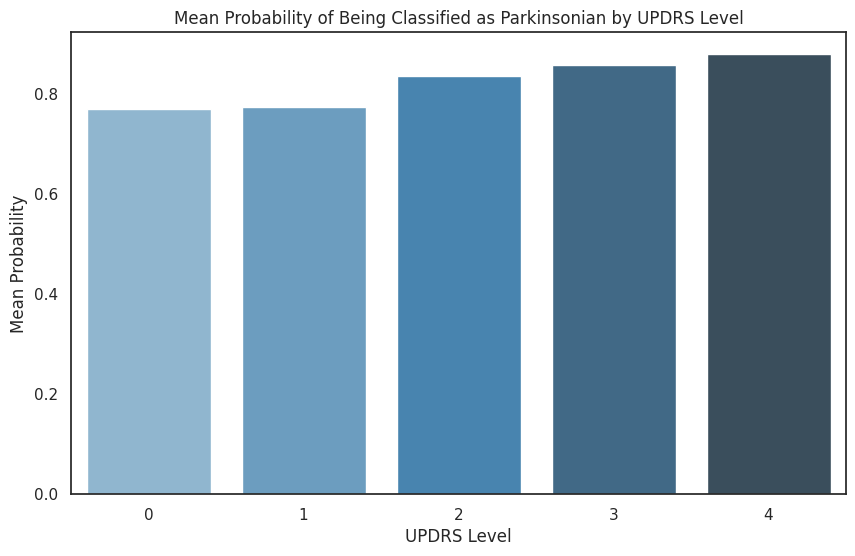

<ipython-input-16-ded3547fb947>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='UPDRS Level', y='Probability', data=df, palette='Pastel1')


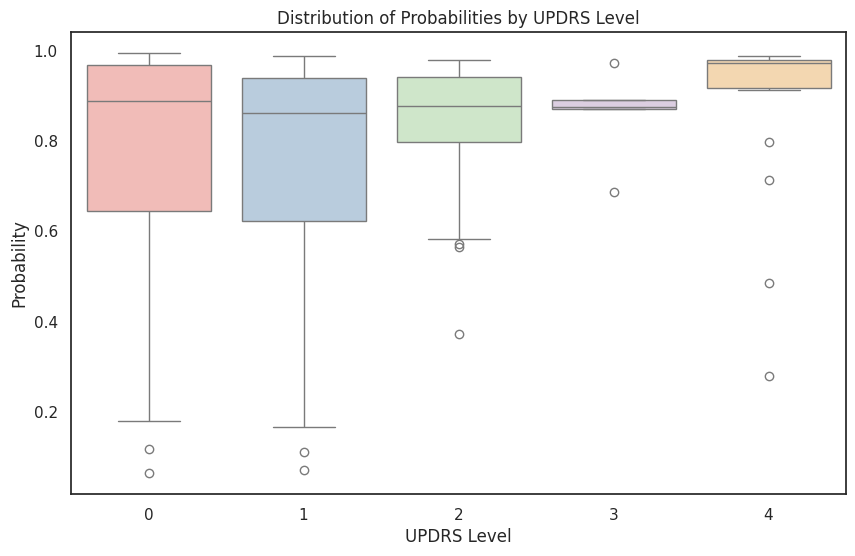

<ipython-input-16-ded3547fb947>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=percentages_classified, palette='Oranges_d')


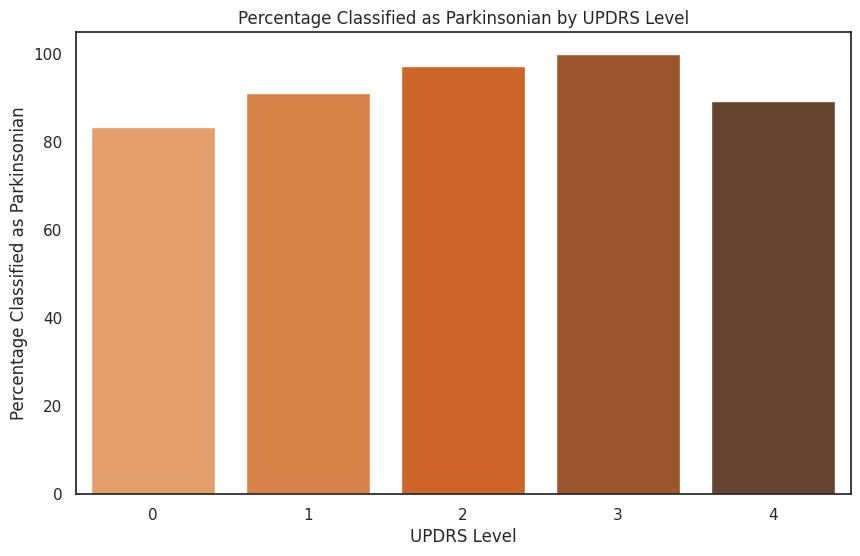

<ipython-input-16-ded3547fb947>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=total_counts, palette='Greens_d')


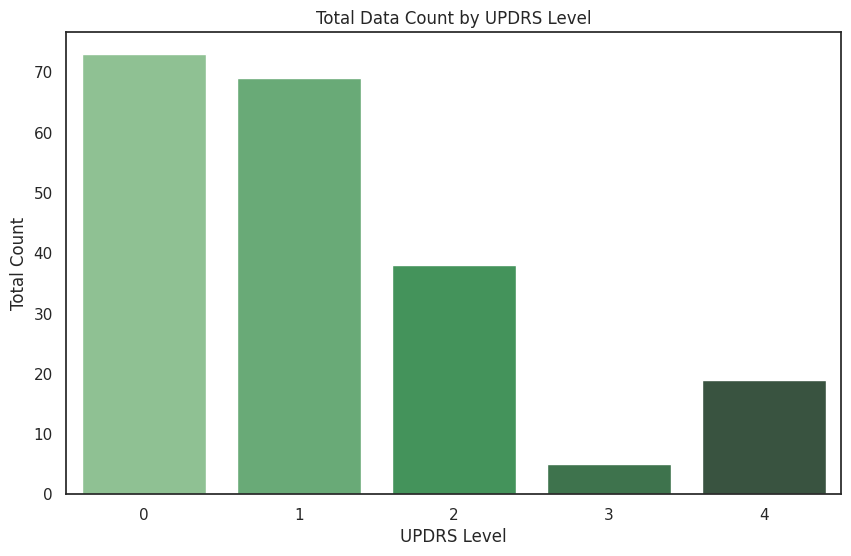

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_updrs_metrics(aggregated_updrs_metrics, probabilities_by_updrs):
    # Prepare data for plotting
    levels = list(aggregated_updrs_metrics.keys())
    total_counts = [aggregated_updrs_metrics[level]['total_count'] for level in levels]
    mean_probs = [aggregated_updrs_metrics[level]['mean_probability'] for level in levels]
    mean_logits = [aggregated_updrs_metrics[level]['mean_logit'] for level in levels]
    percentages_classified = [aggregated_updrs_metrics[level]['percentage_classified_as_parkinsonian'] for level in levels]

    # Bar chart for mean probabilities
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=mean_probs, palette='Blues_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Mean Probability')
    plt.title('Mean Probability of Being Classified as Parkinsonian by UPDRS Level')
    plt.show()

    # Boxplot for probabilities
    plt.figure(figsize=(10, 6))
    data = [(level, prob) for level, probs in probabilities_by_updrs.items() for prob in probs]
    df = pd.DataFrame(data, columns=['UPDRS Level', 'Probability'])
    sns.boxplot(x='UPDRS Level', y='Probability', data=df, palette='Pastel1')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Probability')
    plt.title('Distribution of Probabilities by UPDRS Level')
    plt.show()

    # Bar chart for percentage classified as Parkinsonian
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=percentages_classified, palette='Oranges_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Percentage Classified as Parkinsonian')
    plt.title('Percentage Classified as Parkinsonian by UPDRS Level')
    plt.show()

    # Bar chart for total count
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=total_counts, palette='Greens_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Total Count')
    plt.title('Total Data Count by UPDRS Level')
    plt.show()

# Call the function after calculating metrics
plot_updrs_metrics(aggregated_updrs_metrics, probabilities_by_updrs)